In [1]:
import numpy as np
import scipy.integrate as integ
import scipy.interpolate as interp


import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)
import cython
%load_ext Cython

In [263]:
%%cython

import numpy as np
import cython
cimport numpy as np

cimport cython
ctypedef np.double_t DTYPE_t

from libc.math cimport exp
from libc.math cimport sqrt

from cython.parallel import prange

# first derivative
@cython.boundscheck(False)  # Deactivate bounds checking
cpdef dfdA(np.ndarray arr, double deltaL, double [::1] A, double bd = 0, int exec_pos = -1):
    cdef int size = arr.shape[0]
    cdef double [:] f = arr
    cdef double [:] res =  np.zeros(size, dtype=np.double)
    
    cdef int i
    for i in prange(exec_pos+2, size - 1,nogil=True):
        res[i] = (f[i+1] - f[i-1]) / (A[i+1] - A[i-1])
    if(exec_pos > -1):
        res[exec_pos+1] = (f[exec_pos+2] - f[exec_pos+1]) / (A[exec_pos+2]-A[exec_pos+1]) 
    elif(bd < 1e99): # if bd value is valid, set 0th component to bd
        res[0] = bd
    else: # invalid bd value, so use one-side derivative
        res[0] = (f[1] - f[0]) / (A[1] - A[0])
    res[size - 1] = (f[-1] - f[-2]) / (A[size - 1] - A[size-2]) 
    return np.asarray(res)

# second derivative
@cython.boundscheck(False)  # Deactivate bounds checking
cpdef ddfddA(np.ndarray arr, double deltaL, double [::1] A, double bd = 0, int exec_pos = -1):
    cdef int size = arr.shape[0]
    cdef double [:] f = arr
    cdef double [:] res =  np.zeros(size, dtype=np.double)
    
    cdef int i
    for i in prange(exec_pos+2, size - 1,nogil=True):
        res[i] = ((f[i+1] - f[i]) / (A[i+1] - A[i]) - (f[i] - f[i-1]) / (A[i] - A[i-1])) \
            / (0.5 * (A[i+1] - A[i-1]))
    if(exec_pos > -1):
        res[exec_pos+1] = res[exec_pos+2]
    else:
        res[0] = (f[1] + f[1] - 2 * f[0]) /(A[1]**2)
    res[size - 1] = (f[-3] + f[-1] - 2*f[-2]) / ( (A[-1] - A[-3])/2 )**2 
    return np.asarray(res)

@cython.boundscheck(False)  # Deactivate bounds checking
cpdef derv_phi(np.ndarray rho, np.ndarray P, double off_set=0, int exec_pos = -1):
    cdef int size = rho.shape[0]
    cdef double [:] res =  np.zeros(size, dtype=np.double)
    cdef int i
    res[exec_pos + 1] = off_set
    res[exec_pos+2] = - (P[exec_pos+2] - P[exec_pos+1]) / (P[exec_pos+1] + rho[exec_pos+1]) + res[exec_pos+1]

    for i in range(exec_pos+3, size):
        res[i] = - (P[i] - P[i-2]) / (P[i-1] + rho[i-1]) + res[i-2]
    return np.asarray(res)

@cython.boundscheck(False)  # Deactivate bounds checking
cpdef inv_derv_phi(np.ndarray rho, np.ndarray P, double off_set=0, int exec_pos = -1):
    cdef int size = rho.shape[0]
    cdef double [:] res =  np.zeros(size, dtype=np.double)
    cdef int i
    res[size - 1] = off_set
    res[size - 2] =  (P[size-1] - P[size-2]) / (P[size-2] + rho[size-2]) + res[size-1]
    for i in range(size-3, -1, -1):
        res[i] = (P[i+2] - P[i]) / (P[i+1] + rho[i+1]) + res[i+2]
    return np.asarray(res)

@cython.boundscheck(False)  # Deactivate bounds checking
# for exp(\psi) in Eq. 165e
cpdef derv_psi( np.ndarray xi, np.ndarray c, double off_set=0):
    cdef int size = xi.shape[0]
    cdef double [:] res =  np.zeros(size, dtype=np.double)
    cdef int i
    res[0] = off_set
    res[1] = - (xi[2] - xi[1]) * c[0] + res[0]

    for i in range(2, size):
        res[i] = - (xi[i] - xi[i-2]) * c[i - 1] + res[i-2]
    return np.asarray(res)

@cython.boundscheck(False)  # Deactivate bounds checking
# for exp(\psi) in Eq. 165e
cpdef inv_derv_psi( np.ndarray xi, np.ndarray c, double off_set=0):
    cdef int size = xi.shape[0]
    cdef double [:] res =  np.zeros(size, dtype=np.double)
    cdef int i
    res[size - 1] = off_set
    res[size - 2] =  (xi[size-1] - xi[size-2]) * c[size-2] + res[size-1]
    for i in range(size-3, -1, -1):
        res[i] = (xi[i+2] - xi[i]) * c[i+1] + res[i+2]
    return np.asarray(res)

@cython.boundscheck(False)  # Deactivate bounds checking
cpdef find_exec_pos(np.ndarray arr):
    cdef int size = arr.shape[0]
    cdef double [:] f = arr
    
    cdef int i
    for i in range(size - 1, 1,-1):
        if(arr[i] < 1 and arr[i-1] > 1): # found a horizon
            return i-1
    return -1


@cython.boundscheck(False)  # Deactivate bounds checking
cpdef p_prime(np.ndarray g_in, double [:] R, double [:] m, double [:] U, 
                double [:] A, double [:] xi, 
               double [:] gp, double [:] Rp, double [:] Up, double [:] mp, double [:] xip,
               double [:] gpp, double [:] Rpp, double [:] Upp, double [:] mpp, double [:] xipp,
               double a):
    cdef int size = g_in.shape[0]
    cdef double [:] res =  np.zeros(size, dtype=np.double)
    cdef double [:] g = g_in
    cdef int i
    #for i in prange(0, size - 1,nogil=True):
    #    temp = (m[i] + (A[i] * R[i] * (mp[i] - 2 * m[i] * xip[i])) 
    #                / (3 * (R[i] + A[i] * Rp[i] + A * a * R[i] * xip[i]) ) )
    #    res[i] =  (-(A[i] * R[i] * U[i] + g[i]) * gp[i] * temp
    #              + g[i] * (A[i] * U[i] * Rp[i] + R[i] * (U[i] + A[i] * Up[i]) + gp[i]) * temp 
    #              + g[i] * (1111)) / g[i]**2
    return np.asarray(res)
    
    
@cython.boundscheck(False)  # Deactivate bounds checking
cpdef rho_prime(np.ndarray R_in, double [:] m, double [:] A, double [:] xi,
               double [:] Rp, double [:] mp, double [:] xip,
               double [:] Rpp, double [:] mpp, double [:] xipp, double a):
    cdef int size = R_in.shape[0]
    cdef double [:] res =  np.zeros(size, dtype=np.double)
    cdef double [:] R = R_in
    cdef int i
    for i in prange(0, size - 1,nogil=True):
        res[i] = ((R[i] + A[i] * Rp[i] + A[i] * a * R[i] * xip[i]  ) 
                  * (-2 * mp[i] * xip[i] + mpp[i] - 2 * m[i] * xipp[i]) 
                 - (mp[i] - 2 * m[i] * xip[i] ) * (Rp[i] * (2 + A[i] * a * xip[i]) 
                        + A[i] * Rpp[i] + a * R[i] * (xip[i] + A[i] * xipp[i])) ) \
                / (R[i] + A[i] * Rp[i] + A[i] * a * R[i] * xip[i])**2
    return np.asarray(res)

In file included from /usr/local/lib/python3.8/dist-packages/numpy/core/include/numpy/ndarraytypes.h:1944,
                 from /usr/local/lib/python3.8/dist-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /usr/local/lib/python3.8/dist-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /root/.cache/ipython/cython/_cython_magic_569eec7e1d0ca1d1cc4c74e8df044f7a.c:643:
/usr/local/lib/python3.8/dist-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~


In [180]:
class MS:
    
    def __init__(self, R, m, U, w, alpha, A, rho0, deltaL, L, R0=-1):
        self.R = R
        self.m = m
        self.U = U
        self.w = w
        self.deltaL = deltaL
        self.L = L
        self.A = A
        self.alpha = alpha
        self.N = R.shape[0]
        self.exec_pos = -1


        self.t0 = self.alpha * np.sqrt(3 / (8*np.pi*rho0))
        self.t = t0
        self.xi = 0

        self.RH = self.t0 / self.alpha
        self.Abar = self.A / self.RH
        self.Abar_h = self.to_h(self.A)
        
        self.q = 1
        self.deltau_i = self.cfl_deltau(R, m, U) * 0.1
        
        # initialize the poton
        self.Abar_p = self.Abar[0]
        self.U_p = self.U[0]
        self.m_p = self.m[0]
        self.R_p = self.R[0]
        
        self.U_hm = np.zeros(self.N-1)
        self.m_hm = np.zeros(self.N-1)
        self.R_hm = np.zeros(self.N-1)
        self.xi_hm = np.zeros(self.N-1)
        
        self.U_hm[0] = self.U[0]
        self.m_hm[0] = self.m[0]
        self.R_hm[0] = self.R[0]
        
        if R0 < 0:
            R0 = self.R[0]
        
        self.xi_hm[0] = 0
        return
    # convert to half grid
    def to_h(self,arr):
        return np.concatenate(([arr[0]],(arr[0:-1] + arr[1:]) / 2))
    def to_idx(self, pos):
        return np.searchsorted(self.Abar, pos, "right") - 1
    def gamma(self, R, m, U): 
        return np.sqrt(np.exp(2 * (1 - self.alpha) * self.xi) 
                       + (self.Abar * R)**2 * (U**2 - m))
    def P(self, rho) : 
        return self.w * rho
    def rho(self, R, m):
        return m + (dfdA(m, self.deltaL, self.Abar,0, self.exec_pos) * self.Abar * R)  \
            / (3* (self.Abar * dfdA(R, self.deltaL, self.Abar, 0, self.exec_pos) 
                  + R ))
    def psi(self, rho, p, Pprime):
        #return np.log(rho ** (-3 * self.alpha * self.w / 2))
        offset = + np.log(rho[-1]**(-3 * self.alpha * self.w / 2))
        return inv_derv_phi(rho, p, offset) 
    
    def Pprime(self, R, m):
        mprime = dfdA(m, self.deltaL, self.Abar, 0, self.exec_pos)
        Rprime = dfdA(R, self.deltaL, self.Abar, 0, self.exec_pos)
        mpp = ddfddA(m, self.deltaL, self.Abar, 0, self.exec_pos)
        Rpp = ddfddA(R, self.deltaL, self.Abar, 0, self.exec_pos)
        return self.w * (4 * self.Abar**2 * mprime * Rprime**2 
                + R**2 * (4 * mprime + self.Abar * mpp)
               + self.Abar * R * (self.Abar * Rprime * mpp + mprime * (6 * Rprime - self.Abar * Rpp))) \
                / (3 * (R + self.Abar * Rprime)**2)
    def k_coeffs(self, R, m, U, Abar_p) :
        g = self.gamma(R, m, U)
        r = self.rho(R, m)
        p = self.P(r)
        
        Pprime = self.Pprime(R, m)
        ep = np.exp(self.psi(r, p, Pprime))
        #print(g,r,p,ep)
        kR = self.alpha * R * (U * ep - 1)
        km = 2 * m - 3 * self.alpha * U * ep * (p + m)
        
        AR_prime = R + self.Abar * dfdA(R, self.deltaL, self.Abar, 0, self.exec_pos)
        
        kU = U - self.alpha * ep * \
            (   g**2 * np.concatenate( ([self.w
                            * ((m[1] + m[1] - 2 * m[0]) /( self.Abar[1]**2)) *  (1**2 * 5/3)] ,Pprime[1:] / 
             (self.Abar[1:]) ))  / (R * (AR_prime) * (r + p))  
            + (2 * U**2 + m + 3 * p) / 2) 

        kA_p = self.alpha * interp.griddata(self.Abar, ep * g / AR_prime, 
                                            Abar_p, method='linear') 
        #kA_p.fill(0)
        return kR, km, kU, kA_p
    

    
    def run_steps(self,n_steps, exc_intv=0) :
        step = 0
        
        deltau = self.deltau_i
        while(step < n_steps) :
            #deltau = self.cfl_deltau(self.R, self.m, self.U) * 0.9
            #if(self.to_idx(self.Abar_p) > 100 and self.to_idx(self.Abar_p)<self.N * 0.9):
            if(self.to_idx(self.Abar_p) > 100):
                self.exec_pos = np.max([self.exec_pos, self.to_idx(self.Abar_p) - 10])
            exec_arr = np.concatenate(([0] * (self.exec_pos+1),[1] * (self.N - self.exec_pos - 1)))
            #if(self.exec_pos > 0):
                #print('Performing excision at pos '+ str(self.exec_pos))
            kR1, km1, kU1, kA_p1 = self.k_coeffs(self.R, self.m, self.U, self.Abar_p)
            kR2, km2, kU2, kA_p2 = self.k_coeffs(self.R + deltau/2*kR1, self.m + deltau/2*km1, 
                                                 self.U + deltau/2*kU1, self.Abar_p + deltau/2*kA_p1)
            kR3, km3, kU3, kA_p3 = self.k_coeffs(self.R + deltau/2*kR2, self.m + deltau/2*km2, 
                                                 self.U + deltau/2*kU2, self.Abar_p + deltau/2*kA_p2)
            kR4, km4, kU4, kA_p4 = self.k_coeffs(self.R + deltau*kR3, self.m + deltau*km3, 
                                                 self.U + deltau*kU3, self.Abar_p + deltau*kA_p3)
            
            self.R = self.R + (deltau/6*(kR1 + 2*kR2 + 2*kR3 + kR4)) * exec_arr
            self.m = self.m + (deltau/6*(km1 + 2*km2 + 2*km3 + km4)) * exec_arr
            self.U = self.U + (deltau/6*(kU1 + 2*kU2 + 2*kU3 + kU4)) * exec_arr
            
            Abar_p_new = self.Abar_p + deltau/6*(kA_p1 + 2*kA_p2 + 2*kA_p3 + kA_p4)
            idx_p_new = self.to_idx(Abar_p_new)
            U_p_new = interp.griddata(self.Abar, self.U, Abar_p_new, method='linear')
            m_p_new = interp.griddata(self.Abar, self.m, Abar_p_new, method='linear')
            R_p_new = interp.griddata(self.Abar, self.R, Abar_p_new, method='linear')
            #print(kA_p1, kA_p2, kA_p3, kA_p4, deltau, Abar_p_new)
            diff = idx_p_new - self.to_idx(self.Abar_p)
            if (diff > 1): ##move across more than two grid pints!
                print('Warning!' + str(self.Abar_p) + ' ' + str(Abar_p_new))
                #break
            if ( diff > 0): # move across one grid point            
                interp_w = (self.Abar[idx_p_new] - self.Abar_p) / (Abar_p_new - self.Abar_p)
                # linear interpolation
                self.U_hm[idx_p_new] = U_p_new * interp_w + self.U_p * (1 - interp_w)
                self.m_hm[idx_p_new] = m_p_new * interp_w + self.m_p * (1 - interp_w)
                self.R_hm[idx_p_new] = R_p_new * interp_w + self.R_p * (1 - interp_w)
                self.xi_hm[idx_p_new] = self.xi + deltau * interp_w
            
            if(self.xi >= self.xi_hm[0]): #only start advancing photon when the system time is large enough
                self.Abar_p = Abar_p_new
                self.U_p = U_p_new
                self.m_p = m_p_new
                self.R_p = R_p_new
            
            step+=1
            self.xi += deltau
            if(idx_p_new == self.N-2): #going out of the boundary
                break
        if step < n_steps:
            print("Photon has gone out of the outter boundary!")
  
    def run_steps_rk2(self,n_steps) :
        step = 0
        
        #deltau = self.cfl_deltau(R, m, U) * 0.9
        deltau = self.deltau_i
        while(step < n_steps) :
            #deltau = self.cfl_deltau(R, m, U) * 0.9
            kR1, km1, kU1 = self.k_coeffs(self.R, self.m, self.U)
            kR2, km2, kU2 = self.k_coeffs(self.R + deltau/2*kR1, self.m + deltau/2*km1, self.U + deltau/2*kU1)


            self.R = self.R + deltau * kR2 
            self.m = self.m + deltau * km2 
            self.U = self.U + deltau * kU2
            
            step+=1
            self.xi += deltau
            
    def adap_run_steps(self,n_steps, adjust_steps=100, tol=1e-7) :
        step = 0
        deltau = self.deltau_i
        #q = 1
        while(step < n_steps) :
            #if (step % adjust_steps == 0): # reset_stepping size
            #    deltau = self.cfl_deltau(R, m, U) * 0.9
            #    q = 1
            
            kR1, km1, kU1 = self.k_coeffs(self.R, self.m, self.U)
            
            kR2, km2, kU2 = self.k_coeffs(self.R + deltau/2*kR1, self.m + deltau/2*km1, self.U + deltau/2*kU1)
            
            kR3, km3, kU3 = self.k_coeffs(self.R + 3*deltau/4*kR2, self.m + 3*deltau/4*km2, self.U + 3*deltau/4*kU2)

            

            R_new = self.R + deltau/9*(2*kR1 + 3*kR2 + 4*kR3 )
            m_new = self.m + deltau/9*(2*km1 + 3*km2 + 4*km3 )
            U_new = self.U + deltau/9*(2*kU1 + 3*kU2 + 4*kU3 )
            
            kR4, km4, kU4 = self.k_coeffs(R_new , m_new , U_new )
            
            E_R = np.max( np.abs((deltau * (-5*kR1/72 + kR2/12 + kR3/9 - kR4/8))))
            E_m = np.max( np.abs(deltau * (-5*km1/72 + km2/12 + km3/9 - km4/8)))
            E_U = np.max( np.abs(deltau * (-5*kU1/72 + kU2/12 + kU3/9 - kU4/8)))
    
            max_err_R = np.max(np.abs(self.R)) * tol
            max_err_m = np.max(np.abs(self.m)) * tol
            max_err_U = np.max(np.abs(self.U)) * tol
            
            if(E_R < max_err_R and E_m < max_err_m and E_U < max_err_U):
                self.R = R_new
                self.m = m_new
                self.U = U_new
                
                kR1 = kR4
                km1 = km4
                kU1 = kU4
                
                step+=1
                self.xi += deltau
                         
            # Adjust step size.
            self.q = 0.8*np.min((max_err_R/E_R, max_err_m/E_m, max_err_U/E_U) )**(1/3)   # conservative optimal step factor
            self.q = min(self.q,10)               # limit stepsize growth
            deltau *= self.q
            #print(q, E_R, max_err_R)
            
    def cfl_deltau(self,R, m, U):
        a = np.exp(self.alpha * self.xi)
        H = np.exp(-self.xi) / self.RH
        
        g = self.gamma(R, m, U)
        r = self.rho(R, m)
        p = self.P(r)
  
        Pprime = self.Pprime(R, m)
                           
        ep = np.exp(self.psi(r, p, Pprime))
        el = (a * H * self.RH * g) / (dfdA(a * self.A * self.R, self.deltaL, self.Abar, 1) / self.RH) 
        #print(el, ep.min())
        #return (np.log(1 + el / ep / np.exp(self.xi)  
        #               * self.alpha * np.concatenate( ([1e10],(Abar[1:] - Abar[0:-1])) ) / np.sqrt(self.w))).min()
        return (np.log(1 + el / ep / np.exp(self.xi)  
                       * self.alpha * np.concatenate( ([1e10],(self.Abar[1:] - self.Abar[0:-1])) ) / np.sqrt(self.w))).min()

In [489]:
class HM:
    
    def __init__(self, MS):
        self.R = MS.R_hm
        self.m = MS.m_hm
        self.U = MS.U_hm
        self.xi = MS.xi_hm
        self.N = MS.R_hm.shape[0]
        
        self.w = MS.w
        self.deltaL = MS.deltaL
        self.L = MS.L
        self.A = MS.A[:self.N]
        self.alpha = MS.alpha


        self.t0 = MS.t0
        self.t = t0
        self.u = 0

        self.RH = self.t0 / self.alpha
        self.Abar = MS.Abar[:self.N]
        
        self.q = 1
        self.deltau_i = self.cfl_deltau(self.R, self.m, self.U, self.xi) * 0.02
        
        
        return
    # convert to half grid
    def to_h(self,arr):
        return np.concatenate(([arr[0]],(arr[0:-1] + arr[1:]) / 2))

    def gamma(self, R, m, U): 
        return np.sqrt(np.exp(2 * (1 - self.alpha) * self.xi) 
                       + (self.Abar * R)**2 * (U**2 - m))
    def P(self, rho) : 
        return self.w * rho
    def rho(self, R, m, U, xi, g, xiprime, Rprime, mprime):
        temp = (g + self.Abar * R * U) / (g - (self.w ) * self.Abar * R * U ) \
            * (m + self.Abar * R * (mprime - 2 * m * xiprime) 
               / (3 * (self.alpha * self.Abar * R * xiprime + R + self.Abar * Rprime)))
        #temp[-1] = 0.98164112512
        return temp
        return (g + self.Abar * R * U) / (g - (self.w ) * self.Abar * R * U ) \
            * (m + self.Abar * R * (mprime - 2 * m * xiprime) 
               / (3 * (self.alpha * self.Abar * R * xiprime + R + self.Abar * Rprime)))
    def ephi(self, R, U, g, xiprime, Rprime):
        #return (self.alpha * xiprime * self.Abar * R + self.Abar * Rprime + R) 
    
        return (self.alpha * xiprime * self.Abar * R + self.Abar * Rprime + R) \
            / (self.alpha * xiprime* (g + self.Abar * R * U))
    
    def elambda(self, ephi, exi, xiprime):
        return self.alpha * ephi * exi * xiprime
    
    def epsi(self, R, U, g, xi, rho, ephi):
        c = self.alpha - 1 + ephi * self.Abar * R * rho * (1 + self.w) /\
            ((g + self.Abar * R * U) * (1+self.w))
        #offset = 0
        #temp = derv_psi(xi, c, offset)
        offset = np.log(1/ephi[-1] * (g[-1] + self.Abar[-1] * R[-1] * U[-1])) 
        temp = inv_derv_psi(xi, c, offset)
        return  (g + self.Abar * R * U) / np.exp(temp)
    def drho(self, R, m, U, g, xi, Rp, mp, xip):
        Rpp = ddfddA(R, self.deltaL, self.Abar, 0)
        mpp = ddfddA(m, self.deltaL, self.Abar, 0)
        xipp = ddfddA(xi, self.deltaL, self.Abar, 0)
        
        A1p = dfdA(m * (g + self.Abar * R * U) / (g - (self.w ) * self.Abar * R * U ),
                   self.deltaL, self.Abar, 1e100)
        B1 = self.Abar * R * (g + self.Abar * R * U) /(3* (g - (self.w ) * self.Abar * R * U ))
        B1p = dfdA(B1,self.deltaL, self.Abar, 1e100)
        B2 = (mp -2 * m * xip) / (self.alpha * self.Abar * R * xip + R + self.Abar * Rp)
        B2p = rho_prime(R, m, self.Abar, xi, Rp, mp, xip, Rpp, mpp, xipp, self.alpha)
        return A1p + B1p * B2 + B1 * B2p
    
            
    def k_coeffs(self, R, m, U, xi) :
        xiprime = dfdA(xi, self.deltaL, self.Abar, 1e100)
        Rprime = dfdA(R, self.deltaL, self.Abar, 1e100)
        mprime = dfdA(m, self.deltaL, self.Abar, 1e100)
        Uprime = dfdA(U, self.deltaL, self.Abar, 1e100)
        
        #xiprime.fill(1)
        
        g = self.gamma(R, m, U)
        r = self.rho(R, m, U, xi, g, xiprime, Rprime, mprime)
        p = self.P(r)
        
        #g.fill(1)
        
        exi = np.exp(xi)
        ephi = self.ephi(R, U, g, xiprime, Rprime)
        elambda = self.elambda(ephi, exi, xiprime)
        epsi = self.epsi(R, U, g, xi, r, ephi)
        
        #drho = dfdA(r, self.deltaL, self.Abar, 0)
        drho = self.drho(R, m, U, g, xi, Rprime, mprime, xiprime)
        
        kxi = epsi / ephi / np.exp(xi) / self.alpha
        
        kR = epsi / exi * R * (U - 1/ephi)
        
        km = 3 * epsi / exi * (1/ephi * m * (1+w) - U * (p +m)) 
                
        kU = - epsi / exi / (1 - w) * (
            (m + 3 * p) / 2 + U**2 - U / self.alpha / ephi 
        + (w) * exi / elambda * Uprime + g * (w) / ( np.concatenate( ([1], self.Abar[1:]) ) * R * (1+w)) * (
         + 3 * (1 + w) * (U - 1 / ephi) + exi / elambda * drho / r) )
        
        # boundary conditions 
        kxi[0] = epsi[0] / elambda[0] * (xi[1] - xi[0]) / ( (self.Abar[1] - self.Abar[0]) )
        kR[0] = epsi[0] / elambda[0] * (R[1] - R[0]) / ( (self.Abar[1] - self.Abar[0]) )
        km[0] = epsi[0] / elambda[0] * (m[1] - m[0]) / ( (self.Abar[1] - self.Abar[0]) )
        kU[0] = epsi[0] / elambda[0] * (U[1] - U[0]) / ( (self.Abar[1] - self.Abar[0]) )
        
        return kxi, kR, km, kU
    

    
    def run_steps(self,n_steps, exc_intv=0) :
        step = 0
        
        deltau = self.deltau_i
        while(step < n_steps) :

            kxi1, kR1, km1, kU1 = self.k_coeffs(self.R, self.m, self.U,  self.xi)
            kxi2, kR2, km2, kU2 = self.k_coeffs(self.R + deltau/2*kR1, self.m + deltau/2*km1, 
                                                 self.U + deltau/2*kU1, self.xi)
            kxi3, kR3, km3, kU3 = self.k_coeffs(self.R + deltau/2*kR2, self.m + deltau/2*km2, 
                                                 self.U + deltau/2*kU2, self.xi)
            kxi4, kR4, km4, kU4 = self.k_coeffs(self.R + deltau*kR3, self.m + deltau*km3, 
                                                 self.U + deltau*kU3,  self.xi)
            
            self.xi = self.xi + (deltau/6*(kxi1 + 2*kxi2 + 2*kxi3 + kxi4)) 
            self.R = self.R + (deltau/6*(kR1 + 2*kR2 + 2*kR3 + kR4)) 
            self.m = self.m + (deltau/6*(km1 + 2*km2 + 2*km3 + km4))
            self.U = self.U + (deltau/6*(kU1 + 2*kU2 + 2*kU3 + kU4))
            
            step+=1
            self.u += deltau
        if self.u > 1100:
            print("Photon has gone out of the outter boundary!")
              
    def cfl_deltau(self,R, m, U, xi):
        xiprime = dfdA(xi, self.deltaL, self.Abar, 1e100)
        Rprime = dfdA(R, self.deltaL, self.Abar, 1e100)
        mprime = dfdA(m, self.deltaL, self.Abar, 1e100)
        Uprime = dfdA(U, self.deltaL, self.Abar, 1e100)
        #print((xiprime ))
        g = self.gamma(R, m, U)
        r = self.rho(R, m, U, xi, g, xiprime, Rprime, mprime)
        p = self.P(r)
        exi = np.exp(xi)
        ephi = self.ephi(R, U, g, xiprime, Rprime)
        elambda = self.elambda(ephi, exi, xiprime)
        epsi = self.epsi(R, U, g, xi, r, ephi)
 
        return ((1 / np.sqrt(w) - 1)  * (Abar[1] - Abar[0]) * elambda / epsi).min()
    

In [463]:
def mix_grid(left, right, n):
    A = np.exp(np.linspace(left, right, n))
    dA = A[1] - A[0]
    A = np.concatenate( (np.linspace(0, A[0],int(np.ceil(A[0] / dA)), endpoint=False), A))
    return A

In [ ]:
def uni_grid( right, n):
    A = np.linspace(0, right, n)
    return A

In [477]:
n=500

#L = np.linspace(-6, 1.5, n)
#A = np.exp(L)
A = np.linspace(0, np.exp(1.5), n)
A = mix_grid(-3,1.5,n)

w = 1 / 3
alpha = 1/2 # alpha = 1/2 for w = 1/3


rho0 = 1
t0 = alpha * np.sqrt(3 / (8*np.pi*rho0))
RH = t0 / alpha
Abar = A / RH

deltaL = 0

deltaA = Abar[1] - Abar[0]

amp = 0.3
delta0 = amp * np.exp(-2 * Abar**2 / RH / 30)
delta0P = amp * delta0 * 2 * (-2 / RH / 30 ) * Abar

m = 1 + delta0 
U = 1 - alpha * delta0 / 2
R = 1 - alpha / 2 * (delta0 + w * Abar * delta0P / (1 + 3 * w) )


ms = MS(R,m,U,w,alpha,A,rho0, deltaL,L, 1 - alpha / 2 * (amp ))

In [432]:
hm.cfl_deltau(hm.R, hm.m, hm.U,hm.xi)

2.675557332206452

In [478]:
ms.run_steps(153050)

Photon has gone out of the outter boundary!


In [409]:
import copy
ms_std = copy.copy(ms)

In [490]:
hm = HM(ms)

In [502]:
import copy
hm_bak = copy.copy(hm)

In [419]:
hm = copy.copy(hm_bak)

In [ ]:
hm.run_steps(2000000)

In [ ]:
3+3

In [ ]:
hm.u

In [402]:
hm.u

1275.5100367470268

In [386]:
hm_bak.u

1082.2509402684757

(0.0, 10.0)

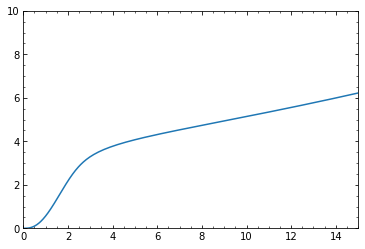

In [493]:
a = np.exp(hm.alpha * hm.xi)
H = np.exp(-hm.xi) / hm.RH
rho_b = a**(1+hm.w)
Rb = a * hm.A
plt.plot(hm.R * Rb ,  (np.exp(-hm.xi/2) * hm.R **3 * hm.Abar**3 * hm.m ) / 2 )
plt.xlim(0,15)
plt.ylim(0,10)
#plt.yscale('log')

(449.0, 499.0)

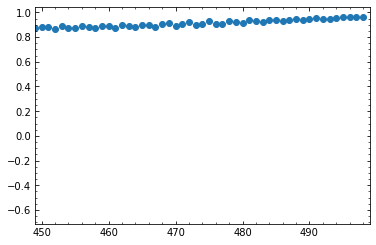

In [344]:
plt.scatter(np.arange(hm.N), hm.U[:])
plt.xlim(hm.N-50,hm.N)
#plt.ylim(0,30)

In [334]:
r[-1]

0.9816411251200977

(0.0, 500.0)

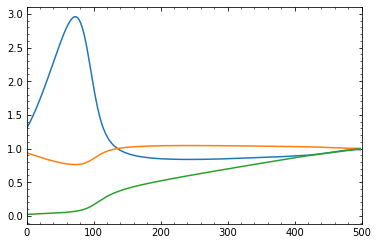

In [333]:
        xiprime = dfdA(hm.xi, hm.deltaL, hm.Abar, 1e100)
        Rprime = dfdA(hm.R, hm.deltaL, hm.Abar, 1e100)
        mprime = dfdA(hm.m, hm.deltaL, hm.Abar, 1e100)


        
        #xiprime.fill(1)
        
        g = hm.gamma(hm.R, hm.m, hm.U)
        r = hm.rho(hm.R, hm.m, hm.U, hm.xi, g, xiprime, Rprime, mprime)
        exi = np.exp(hm.xi)
        ephi = hm.ephi(hm.R, hm.U, g, xiprime, Rprime)
        elambda = hm.elambda(ephi, exi, xiprime)
        epsi = hm.epsi(hm.R, hm.U, g, hm.xi, r, ephi)

        plt.plot(np.arange(hm.N), r)
        plt.plot(np.arange(hm.N), ephi)
        plt.plot(np.arange(hm.N), epsi)
        plt.xlim(0,500)
#plt.ylim(0.915,0.93)

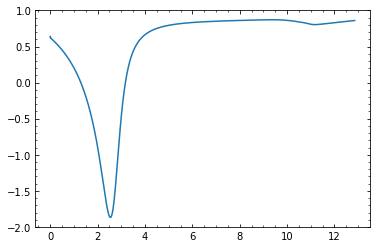

In [495]:
plt.plot(hm.Abar[:], hm.U[:])
#plt.plot(hm_bak.Abar[:], hm_bak.U[:])


#plt.xlim(0,30)
#plt.ylim(-10,-19.5)

In [429]:
(hm.R**2 * hm.m * hm.Abar**2 * np.exp(2*(hm.alpha-1)*hm.xi)).max()

0.9566891994611474

(0.0, 1.0)

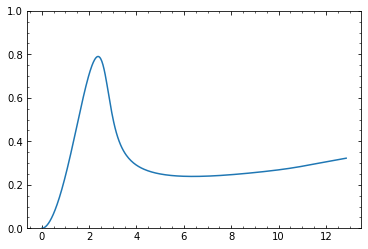

In [500]:
plt.plot(hm.Abar, hm.R**2 * hm.m * hm.Abar**2 * np.exp(2*(hm.alpha-1)*hm.xi))
#plt.plot(hm.Abar, hm_bak.R**2 * hm_bak.m * hm_bak.Abar**2 * np.exp(2*(hm_bak.alpha-1)*(hm_bak.xi)))


#plt.xlim(0,300)
plt.ylim(0.,1)

(0.0, 4.0)

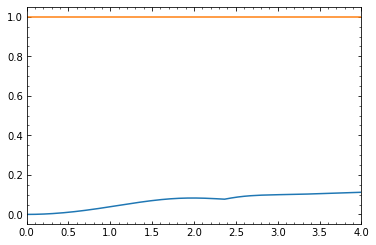

In [175]:
plt.plot(Abar, ms.R**2 * ms.m * ms.Abar**2 * np.exp(2 * (ms.alpha-1) * ms.xi))
plt.plot(Abar, np.array([1]*n))
plt.xlim(0,4)

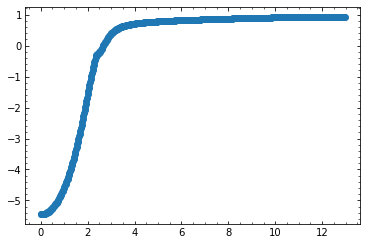

In [185]:
plt.scatter(Abar[:], ms.U[:])
#plt.xlim(0,30)
#plt.ylim(0,1)

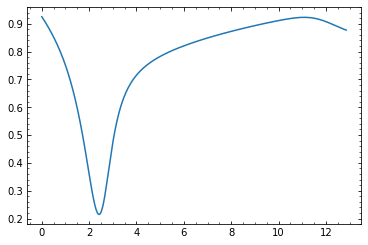

In [480]:
plt.plot(ms.Abar[:ms.N-1], ms.U_hm[:ms.N-1])



In [194]:
hm.deltau_i

0.038651819295227194

In [618]:
import copy
ms_std = copy.copy(ms)

In [665]:
ms = copy.copy(ms_std)

In [1026]:
hm = HM(ms)

In [7]:
hm.run_steps(2000)

NameError: name 'hm' is not defined

In [820]:
import copy
hm_bak = copy.copy(hm)

In [933]:
import copy
hm_bak2 = copy.copy(hm)

In [1009]:
hm = copy.copy(hm_bak2)

In [977]:
import copy
hm_bak3 = copy.copy(hm)

In [953]:
hm.u / hm.deltau_i / 10

142219.99999575678

(0.0, 10.0)

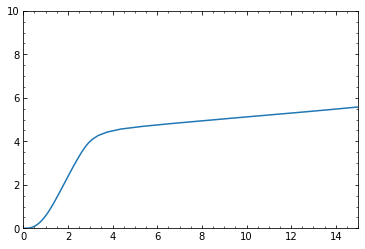

In [1024]:
a = np.exp(hm.alpha * hm.xi)
H = np.exp(-hm.xi) / hm.RH
rho_b = a**(1+hm.w)
Rb = a * hm.A
plt.plot(hm.R * Rb ,  (np.exp(-hm.xi/2) * hm.R **3 * hm.Abar**3 * hm.m ) / 2 )
plt.xlim(0,15)
plt.ylim(0,10)
#plt.yscale('log')

In [ ]:
plt.plot(hm.Abar, hm.m)
plt.plot(hm_bak.Abar, hm_bak.m)


#plt.xlim(0,300)

(0.0, 300.0)

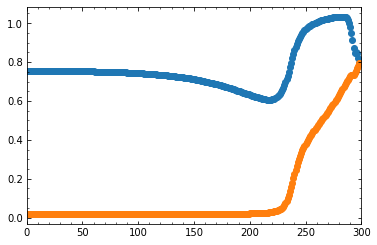

In [784]:
        xiprime = dfdA(hm.xi, hm.deltaL, hm.Abar, 0)
        Rprime = dfdA(hm.R, hm.deltaL, hm.Abar, 0)
        mprime = dfdA(hm.m, hm.deltaL, hm.Abar, 0)


        
        #xiprime.fill(1)
        
        g = hm.gamma(hm.R, hm.m, hm.U)
        r = hm.rho(hm.R, hm.m, hm.U, hm.xi, g, xiprime, Rprime, mprime)
        exi = np.exp(hm.xi)
        ephi = hm.ephi(hm.R, hm.U, g, xiprime, Rprime)
        elambda = hm.elambda(ephi, exi, xiprime)
        epsi = hm.epsi(hm.R, hm.U, g, hm.xi, r, ephi)
        plt.scatter(np.arange(hm.N), ephi)
        plt.scatter(np.arange(hm.N), epsi)
        plt.xlim(0,300)
#plt.ylim(0.915,0.93)

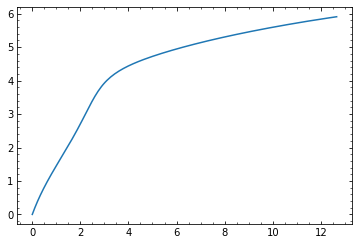

In [832]:
plt.plot(hm.Abar,  hm.xi-0)


#plt.xlim(0,300)
#plt.ylim(0.915,0.93)

In [1012]:
( hm.R**2 * hm.m * hm.Abar**2 * np.exp(2*(hm.alpha-1)*hm.xi)).max()

0.9326803234148633

(0.0, 1.0)

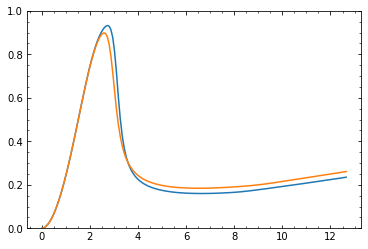

In [1011]:
plt.plot(hm.Abar, hm.R**2 * hm.m * hm.Abar**2 * np.exp(2*(hm.alpha-1)*hm.xi))
plt.plot(hm.Abar, hm_bak.R**2 * hm_bak.m * hm_bak.Abar**2 * np.exp(2*(hm_bak.alpha-1)*(hm_bak.xi)))


#plt.xlim(0,300)
plt.ylim(0.,1)

In [ ]:
plt.plot(hm.Abar, hm.R**2 * hm.m * hm.A**2 * np.exp(2*(hm.alpha-1)*hm.xi))
plt.plot(hm.Abar, hm_bak.R**2 * hm_bak.m * hm_bak.A**2 * np.exp(2*(hm_bak.alpha-1)*hm_bak.xi))


#plt.xlim(0,300)
#plt.ylim(0.915,0.93)

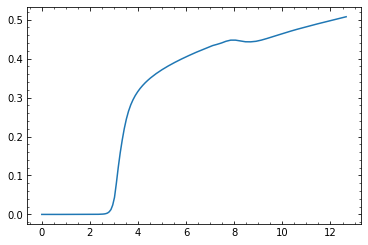

In [1010]:
        xiprime = dfdA(hm.xi, hm.deltaL, hm.Abar, 0)
        Rprime = dfdA(hm.R, hm.deltaL, hm.Abar, 0)
        mprime = dfdA(hm.m, hm.deltaL, hm.Abar, 0)
        Uprime = dfdA(hm.U, hm.deltaL, hm.Abar, 0)
        #print((xiprime ))
        g = hm.gamma(hm.R, hm.m, hm.U)
        r = hm.rho(hm.R, hm.m, hm.U, hm.xi, g, xiprime, Rprime, mprime)
        p = hm.P(r)
        exi = np.exp(hm.xi)
        ephi = hm.ephi(hm.R, hm.U, g, xiprime, Rprime)
        
        epsi = hm.epsi(hm.R, hm.U, g, hm.xi, r, ephi)
        plt.plot(hm.Abar, epsi)

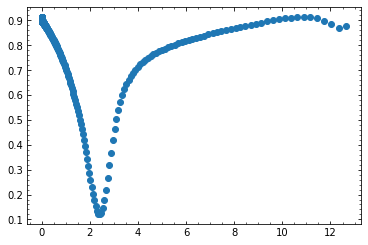

In [763]:
plt.scatter(hm.Abar, hm.U[:])
#plt.xlim(0,30)
#plt.ylim(0,1)

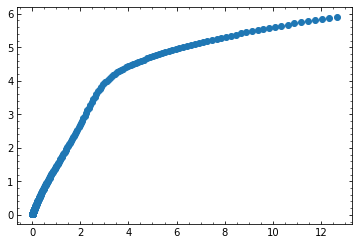

In [884]:
plt.scatter(Abar[:n-1], ms.xi_hm[:])
#plt.xlim(0,30)
#plt.ylim(0,1)

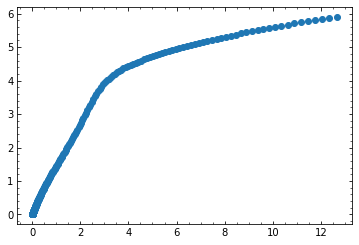

In [883]:
plt.scatter(Abar[:n-1], ms_std.xi_hm[:])
#plt.xlim(0,30)
#plt.ylim(0,1)